In [1]:
import pandas as pd
import numpy as np
import torch 
import math
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torch.optim import Adam

## Look through the data

<AxesSubplot:xlabel='category'>

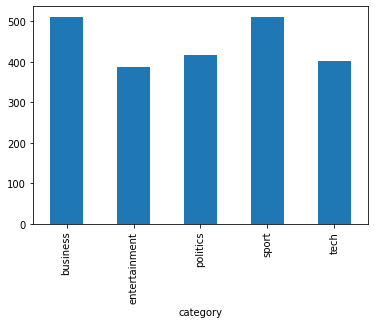

In [2]:
datapath = 'bbc-text.csv'
classification_data= pd.read_csv(datapath)
classification_data.groupby(['category']).size().plot.bar()


In [5]:

class Tokenizer:
    def __init__(self,data, max_length=512):
        self.CLS = '<CLS>'
        self.SEP = '<SEP>'
        self.PAD = '<PAD>'
        self.max_length=max_length
        self.dataloader = DataLoader(data, batch_size=1, collate_fn=self.text)
        self.vocab = build_vocab_from_iterator(map(self.train, self.dataloader), specials=[self.CLS,self.SEP,self.PAD])
                
    def train(self,text):
        tokenization=text.split(" ")
        tokenization=[self.CLS]+tokenization+[self.SEP]
        return tokenization
    def text(self,data_point):
        x,y=data_point[0]
        return y
    def tokenize(self, text):
        tokenization=text.split(" ")
        if(len(tokenization)>(self.max_length-2)):
            tokenization=tokenization[:(self.max_length-2)]
            
        attention_mask=([1]*(len(tokenization)+2))+([0]*(self.max_length-(len(tokenization)+2)))
        tokenization=[self.CLS]+tokenization+[self.SEP]+[self.PAD]*(self.max_length-(len(tokenization)+2))
        inputs_ids=[self.vocab[token] for token in tokenization]
        Input={'input_ids':torch.LongTensor(inputs_ids),'attention_mask':torch.LongTensor(attention_mask)}
        return Input 

    def de_tokenize(self,tokens):
        text=[self.vocab.lookup_token(token) for token in tokens['input_ids']]
        return " ".join(text)
tokenizer=Tokenizer(classification_data.values)

tokenizer.de_tokenize(tokenizer.tokenize(classification_data.values[1000][1]))

'<CLS> parties warned over  grey vote  political parties cannot afford to take older uk voters for granted in the coming election  says age concern.  a survey for the charity suggests 69% of over-55s say they always vote in a general election compared with just 17% of 18 to 24 year olds. charity boss gordon lishman said if a  decisive blow  was struck at the election it would be by older voters who could be relied on to turn out. a total of 3 028 adults aged 18 or over were interviewed for the study. mr lishman urged the next government to boost state pension.  he also called for measures to combat ageism and build effective public services to  support us all in an ageing society .  older people want to see manifesto commitments that will make a difference to their lives   mr lishman said.  political parties must wake up to the fact that unless they address the demands and concerns of older people they will not keep or attract their vote.  in the survey carried out by icm research  14%

In [6]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels_dict={label:n for n,label in enumerate(df['category'].unique())}
        self.labels = [self.labels_dict[label] for label in df['category']]
        self.texts = [tokenizer.tokenize(text) for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [8]:
np.random.seed(112)
df_train, df_val, df_test = np.split(classification_data.sample(frac=1, random_state=42), 
                                     [int(.8*len(classification_data)), int(.9*len(classification_data))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [6]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerClassifier(torch.nn.Module):

    def __init__(self, vocab_size, dropout=0.1, d_model=512, n_labels=5, nhead=16, num_encoder_layers=12, dim_feedforward=2048):

        super(TransformerClassifier, self).__init__()
        self.d_model=d_model
        self.embedding = torch.nn.EmbeddingBag(vocab_size, d_model)
        #self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,dim_feedforward=dim_feedforward)
        self.transformer_model = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(d_model, n_labels)
        self.relu = torch.nn.ReLU()

    def forward(self, input_id, mask):
        embeded=self.embedding(input_id)* math.sqrt(self.d_model)
        #input_encoded=self.pos_encoder(embeded)
        pooled_output = self.transformer_model(src=embeded)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer
    
transformer=TransformerClassifier(vocab_size=tokenizer.vocab.__len__())

In [7]:
EPOCHS = 50
LR = 1e-6

train, val = Dataset(df_train), Dataset(df_val)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=20, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=20)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(transformer.parameters(), lr= LR)

for epoch_num in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    
    for train_input, train_label in tqdm(train_dataloader):
        
        train_label = train_label.to(device)
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)
        
        output=transformer(input_id , mask)
        
        batch_loss = criterion(output, train_label)
        total_loss_train += batch_loss.item()
        
        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train += acc

        transformer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    total_acc_val = 0
    total_loss_val = 0
    with torch.no_grad():

        for val_input, val_label in val_dataloader:

            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)

            output= transformer(input_id , mask)

            batch_loss = criterion(output, val_label)
            total_loss_val += batch_loss.item()

            acc = (output.argmax(dim=1) == val_label).sum().item()
            total_acc_val += acc

    print(
        f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} \
        | Train Accuracy: {total_acc_train / len(df_train): .3f} \
        | Val Loss: {total_loss_val / len(df_val): .3f} \
        | Val Accuracy: {total_acc_val / len(df_val): .3f}')
        

100%|███████████████████████████████████████████| 89/89 [00:32<00:00,  2.75it/s]


Epochs: 1 | Train Loss:  0.081         | Train Accuracy:  0.216         | Val Loss:  0.087         | Val Accuracy:  0.216


 46%|███████████████████▊                       | 41/89 [00:15<00:17,  2.72it/s]


KeyboardInterrupt: 

In [ ]:
1/5

In [ ]:
__getitem__(self, idx)